# **Data Collection and Feature Extraction**

Collecting Data from the dataset and Features are Extracted from those data through their appearance, texture and so on

## Importing Packages

In [ ]:
import os
import sys
import cv2
import shutil
import csv
import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial
from scipy.spatial import QhullError
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from skimage.filters import gabor
from skimage import feature
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage import io, color, transform
from sklearn import datasets
from google.colab import files
from google.colab.patches import cv2_imshow

## Segmentation of Image

In [ ]:
def hsv_mask(image):
  hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  lower_saturation_threshold = 60
  saturation_mask = cv2.inRange(hsv_image[:, :, 1], lower_saturation_threshold, 255)

  kernel_size = (5, 5)
  smoothed_mask = cv2.GaussianBlur(saturation_mask, kernel_size, 0)

  _, leaf_mask = cv2.threshold(smoothed_mask, 1, 255, cv2.THRESH_BINARY)

  kernel = np.ones((5, 5), np.uint8)
  closed_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_CLOSE, kernel)

  segmented_image = image.copy()

  segmented_image[closed_mask == 0] = [0, 0, 0]
  return segmented_image

## Feature Extraction

In [ ]:
def extract_lbp_glcm_features(image):

    lbp = feature.local_binary_pattern(image, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 10))
    lbp_hist = lbp_hist.astype(float)
    lbp_hist /= (lbp_hist.sum() + 1e-6)

    glcm_props=[]
    glcm = feature.graycomatrix((image * 255).astype(np.uint8), [1], [0], symmetric=True, normed=True)
    glcm_props.append(feature.graycoprops(glcm, prop='dissimilarity'))
    glcm_props.append(feature.graycoprops(glcm, prop='contrast'))
    glcm_props.append(feature.graycoprops(glcm, prop='homogeneity'))
    glcm_props.append(feature.graycoprops(glcm, prop='energy'))

    glcm_props.append(feature.graycoprops(glcm, prop='correlation'))
    glcm_props = np.array(glcm_props)
    glcm_props = np.squeeze(glcm_props)

    theta = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    frequency = [0.1, 0.5, 1.0]

    gabor_features = []
    for t in theta:
        for f in frequency:
          gabor_filter_real, _ = gabor(image, frequency=f, theta=t)
          gabor_features.append(np.mean(gabor_filter_real))
    gabor_features = np.array(gabor_features)
    gabor_features = np.squeeze(gabor_features)
    return lbp_hist, glcm_props,gabor_features


In [ ]:
def calculate_color_moments(image):
    channels = cv2.split(image)
    color_moments = []

    for channel in channels:
        mean = np.mean(channel)
        variance = np.var(channel)
        skewness = np.mean((channel - mean) ** 3) / (variance ** (3/2) + 1e-6)

        color_moments.extend([mean, variance, skewness])

    return color_moments

In [ ]:
path="Dataset Path"

In [ ]:
## Extract and Store Features

In [ ]:
csv_filename = '/Data/ExtractedFeatures.csv'
csvfile = open(csv_filename,mode = 'a', newline='')
csv_writer = csv.writer(csvfile)

In [ ]:
for folder_path in os.listdir(path):
  img_path = os.path.join(path,folder_path)
  label=folder_path
  for image_file in os.listdir(img_path):
      image_path = os.path.join(img_path, image_file)
      image = cv2.imread(image_path)
      hsv=hsv_mask(image)
      image_rgb = cv2.cvtColor(hsv, cv2.COLOR_BGR2RGB)
      moments = calculate_color_moments(image_rgb)


      image = color.rgb2gray(image)

      lbp_features, glcm_features,gabor_features = extract_lbp_glcm_features(image)

      gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
      gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
      gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
      gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
      if len(gradient_magnitude.shape) != 2:
        gradient_magnitude = cv2.cvtColor(gradient_magnitude, cv2.COLOR_BGR2GRAY)
      slbp_features, sglcm_features,sgabor_features = extract_lbp_glcm_features(gradient_magnitude)


      app=np.concatenate((lbp_features, glcm_features,gabor_features,slbp_features, sglcm_features,sgabor_features,moments,np.atleast_1d(np.array(label))))
      csv_writer.writerow(app)
      csvfile.flush()


In [ ]:
csvfile.flush()
csvfile.close()

## Image after Segmentation, Grayscale Conversion and applying Sobel Filter

In [ ]:
image = cv2.imread("/content/Mint.png")

(-0.5, 549.5, 549.5, -0.5)

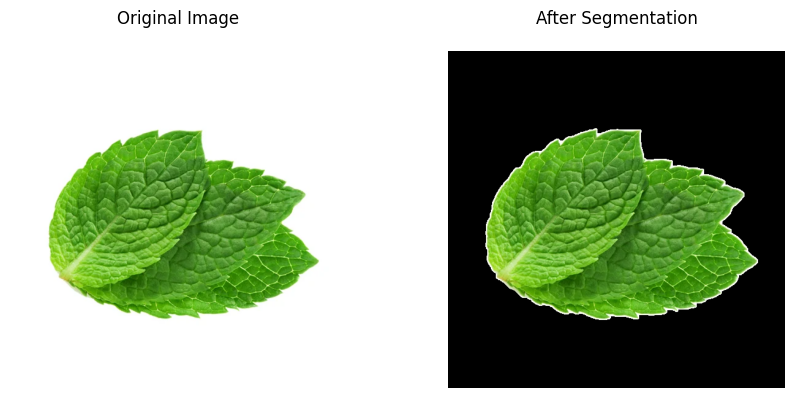

In [ ]:
hsvSegimage = hsv_mask(image)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.3)

axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image', pad=20, fontsize=12, ha='center')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(hsvSegimage, cv2.COLOR_BGR2RGB))
axes[1].set_title('After Segmentation', pad=20, fontsize=12, ha='center')
axes[1].axis('off')

(-0.5, 549.5, 549.5, -0.5)

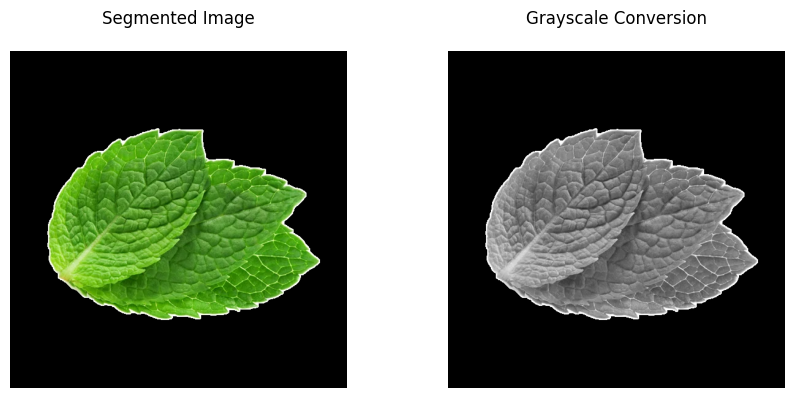

In [ ]:
Grayimage = color.rgb2gray(hsvSegimage)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.3)

axes[0].imshow(cv2.cvtColor(hsvSegimage, cv2.COLOR_BGR2RGB))
axes[0].set_title('Segmented Image', pad=20, fontsize=12, ha='center')
axes[0].axis('off')

axes[1].imshow(Grayimage,cmap='gray')
axes[1].set_title('Grayscale Conversion', pad=20, fontsize=12, ha='center')
axes[1].axis('off')

(-0.5, 549.5, 549.5, -0.5)

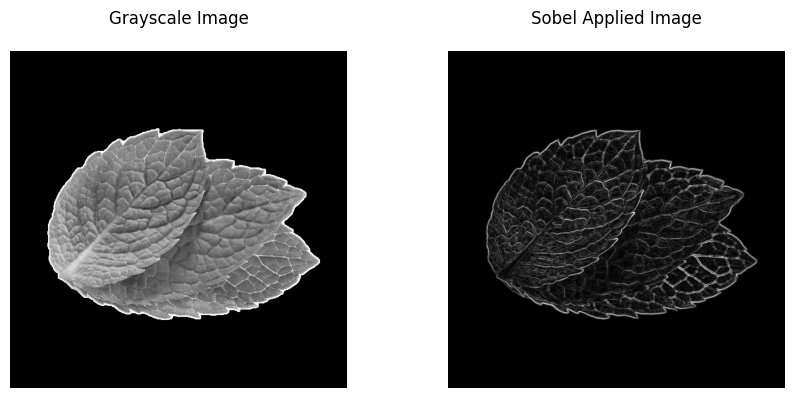

In [ ]:
gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
if len(gradient_magnitude.shape) != 2:
  gradient_magnitude = cv2.cvtColor(gradient_magnitude, cv2.COLOR_BGR2GRAY)
Sobelimage = gradient_magnitude

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.3)

axes[0].imshow(Grayimage,cmap='gray')
axes[0].set_title('Grayscale Image', pad=20, fontsize=12, ha='center')
axes[0].axis('off')

axes[1].imshow(Sobelimage,cmap='gray')
axes[1].set_title('Sobel Applied Image', pad=20, fontsize=12, ha='center')
axes[1].axis('off')  # Turn off axis labels